In [1]:
# import all the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [2]:
# read data file
def read_data(path):
    # read dictionary into df
    df_data_sentence = pd.read_table(path + 'dictionary.txt')
    df_data_sentence_processed = df_data_sentence['Phrase|Index'].str.split('|', expand=True)
    df_data_sentence_processed = df_data_sentence_processed.rename(columns={0: 'Phrase', 1: 'phrase_ids'})

    # read sentiment labels into df
    df_data_sentiment = pd.read_table(path + 'sentiment_labels.txt')
    df_data_sentiment_processed = df_data_sentiment['phrase ids|sentiment values'].str.split('|', expand=True)
    df_data_sentiment_processed = df_data_sentiment_processed.rename(columns={0: 'phrase_ids', 1: 'sentiment_values'})


    # combine data frames containing sentence and sentiment
    df_processed_all = df_data_sentence_processed.merge(df_data_sentiment_processed, how='inner', on='phrase_ids')

    return df_processed_all
df = read_data('data/')
df["sentiment_values"] = df["sentiment_values"].astype(str).astype(float)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [3]:
# mapping the positivity probability(sentiment values to labels)
df["label"] = np.nan
df["label"] = df.apply(lambda x: 'very negative' if x["sentiment_values"] >= 0 and x['sentiment_values'] < 0.2  
                        else 'negative' if x["sentiment_values"] >= 0.2 and x['sentiment_values'] < 0.4
                        else 'neutral' if x["sentiment_values"] >= 0.4 and x['sentiment_values'] < 0.6
                        else 'positive' if x["sentiment_values"] >= 0.6 and x['sentiment_values'] < 0.8
                        else 'very positive', axis=1)

In [4]:
# exploring data
print(df.dtypes)
df = df.drop(['phrase_ids' , 'sentiment_values'], axis =1)
print(df['label'].count())
print(df['label'].value_counts())

Phrase               object
phrase_ids           object
sentiment_values    float64
label                object
dtype: object
239232
neutral          119449
positive          50148
negative          43028
very positive     15255
very negative     11352
Name: label, dtype: int64


Text(0, 0.5, 'Label')

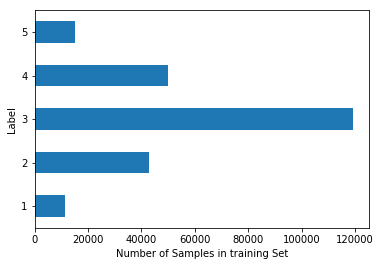

In [11]:
# Data visualization
ax = df['label'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

In [6]:
# Data cleaning and pre-processing 
from nltk.corpus import stopwords
stopwords_set = list(stopwords.words("english"))
df['Phrase'] =  df['Phrase'].apply(lambda x: x.replace('-',' '))
df['Phrase'] =  df['Phrase'].apply(lambda x: re.sub('[^a-zA-Z\s]','', str(x)))
df['Phrase'] =  df['Phrase'].apply(lambda x: re.sub(r"'",'', str(x)))
#df['Phrase'] = df['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_set)]))
df['Phrase'] = df['Phrase'].apply(lambda x: ' '.join([word for word in re.split("\W+",x) if word not in (stopwords_set)]))
df['Phrase'] = df['Phrase'].apply(lambda x: x.lower().strip())

In [7]:
# Dropping string with length < 1
df['distance'] = df.Phrase.apply(lambda x : len(x)>1)
df = df.loc[df.distance, : ]
df = df.drop(['distance'], axis = 1)
df = df.reset_index(drop=True)
#df['Phrase'] = df['Phrase'].apply(lambda x: x if x)
#df['Phrase'] = [x for x in df['Phrase'] if x]
#df['phrase_clean'] = [x for x in df['phrase_clean'] if x]

In [8]:
df['label'].unique()

array(['neutral', 'very positive', 'positive', 'negative',
       'very negative'], dtype=object)

In [9]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['label']]).toarray())
# merge with main df on key values
df = df.join(enc_df)
df

,Phrase,label,0,1,2,3,4
0,alas,neutral,0.0,1.0,0.0,0.0,0.0
1,brilliant,very positive,0.0,0.0,0.0,0.0,1.0
2,brilliant,very positive,0.0,0.0,0.0,0.0,1.0
3,brilliant,very positive,0.0,0.0,0.0,0.0,1.0
4,cmon,neutral,0.0,1.0,0.0,0.0,0.0
5,gollum performance incredible,positive,0.0,0.0,1.0,0.0,0.0
6,oh look clever angle wow jump cut,negative,1.0,0.0,0.0,0.0,0.0
7,romething,neutral,0.0,1.0,0.0,0.0,0.0
8,run,neutral,0.0,1.0,0.0,0.0,0.0
9,the movie,neutral,0.0,1.0,0.0,0.0,0.0


In [10]:
df = df.rename(columns={0: "very negative", 1: "negative", 2: "neutral", 3: "positive", 4: "very positive"})

In [11]:
X = df['Phrase']

In [12]:
# Toekenizing the words
num_words = 500
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
print(tokenizer)
X=tokenizer.fit_on_texts(df['Phrase'])
print(X)
X = tokenizer.texts_to_sequences(df['Phrase'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

max_length_of_text = 100
X = pad_sequences(X, maxlen=max_length_of_text)

None
Found 17907 unique tokens.


In [13]:
y = df[["very negative", "negative", "neutral", "positive", "very positive"]]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
print(X_train.shape,y_train.shape)

(189712, 100) (189712, 5)


In [16]:
X[10]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   3, 344,  50, 207])

In [17]:
# LSTM model
embed_dim = 1024
lstm_out = 128
batch_size = 64

inputs = Input((max_length_of_text,))
x = Embedding(num_words, embed_dim)(inputs)
x = LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4)(x)
x = Dense(5,activation='sigmoid')(x)
model = Model(inputs, x)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 1024)         512000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,102,981
Trainable params: 1,102,981
Non-trainable params: 0
_________________________________________________________________
None


Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

Cross-entropy can be specified as the loss function in Keras by specifying ‘categorical_crossentropy‘ when compiling the model.

In [18]:
# Define loss and optimizer
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['categorical_accuracy'])

In [19]:
# Prevent overfitting through EarlyStopping and saving the model 
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stops = EarlyStopping(patience=3, monitor='val_acc',min_delta=0.001)
checkpointer = ModelCheckpoint(filepath='weights4.best.eda.hdf5', verbose=1, save_best_only=True)

In [20]:
# fit the training and validation data over the model and start the training of the network
model.fit(X_train, y_train,validation_data=(X_test, y_test) ,batch_size = 64, epochs = 2,callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 189712 samples, validate on 47429 samples
Epoch 1/2


  9024/189712 [>.............................] - ETA: 1:18:44 - loss: 1.6260 - categorical_accuracy: 0.109 - ETA: 52:47 - loss: 1.5997 - categorical_accuracy: 0.3281  - ETA: 43:12 - loss: 1.5726 - categorical_accuracy: 0.411 - ETA: 38:30 - loss: 1.5547 - categorical_accuracy: 0.421 - ETA: 35:50 - loss: 1.5287 - categorical_accuracy: 0.443 - ETA: 34:00 - loss: 1.5028 - categorical_accuracy: 0.455 - ETA: 32:34 - loss: 1.4910 - categorical_accuracy: 0.457 - ETA: 31:41 - loss: 1.4799 - categorical_accuracy: 0.449 - ETA: 30:52 - loss: 1.4467 - categorical_accuracy: 0.463 - ETA: 30:12 - loss: 1.4338 - categorical_accuracy: 0.465 - ETA: 29:38 - loss: 1.4061 - categorical_accuracy: 0.475 - ETA: 29:38 - loss: 1.3906 - categorical_accuracy: 0.475 - ETA: 29:46 - loss: 1.3913 - categorical_accuracy: 0.474 - ETA: 29:23 - loss: 1.3899 - categorical_accuracy: 0.473 - ETA: 29:07 - loss: 1.3930 - categorical_accuracy: 0.466 - ETA: 28:48 - loss: 1.3977 - categorical_accuracy: 0.466 - ETA: 28:36 - loss: 

 27072/189712 [===>..........................] - ETA: 23:49 - loss: 1.2455 - categorical_accuracy: 0.508 - ETA: 23:48 - loss: 1.2452 - categorical_accuracy: 0.508 - ETA: 23:47 - loss: 1.2454 - categorical_accuracy: 0.508 - ETA: 23:46 - loss: 1.2449 - categorical_accuracy: 0.508 - ETA: 23:45 - loss: 1.2446 - categorical_accuracy: 0.508 - ETA: 23:44 - loss: 1.2442 - categorical_accuracy: 0.508 - ETA: 23:43 - loss: 1.2437 - categorical_accuracy: 0.509 - ETA: 23:43 - loss: 1.2431 - categorical_accuracy: 0.509 - ETA: 23:42 - loss: 1.2424 - categorical_accuracy: 0.509 - ETA: 23:42 - loss: 1.2421 - categorical_accuracy: 0.509 - ETA: 23:41 - loss: 1.2420 - categorical_accuracy: 0.509 - ETA: 23:40 - loss: 1.2424 - categorical_accuracy: 0.509 - ETA: 23:39 - loss: 1.2416 - categorical_accuracy: 0.509 - ETA: 23:39 - loss: 1.2420 - categorical_accuracy: 0.509 - ETA: 23:39 - loss: 1.2419 - categorical_accuracy: 0.509 - ETA: 23:42 - loss: 1.2419 - categorical_accuracy: 0.509 - ETA: 23:41 - loss: 1.24

 36096/189712 [====>.........................] - ETA: 22:38 - loss: 1.2258 - categorical_accuracy: 0.515 - ETA: 22:37 - loss: 1.2259 - categorical_accuracy: 0.515 - ETA: 22:37 - loss: 1.2259 - categorical_accuracy: 0.515 - ETA: 22:36 - loss: 1.2258 - categorical_accuracy: 0.515 - ETA: 22:35 - loss: 1.2255 - categorical_accuracy: 0.515 - ETA: 22:35 - loss: 1.2257 - categorical_accuracy: 0.515 - ETA: 22:34 - loss: 1.2255 - categorical_accuracy: 0.515 - ETA: 22:33 - loss: 1.2258 - categorical_accuracy: 0.515 - ETA: 22:32 - loss: 1.2259 - categorical_accuracy: 0.515 - ETA: 22:32 - loss: 1.2258 - categorical_accuracy: 0.515 - ETA: 22:31 - loss: 1.2259 - categorical_accuracy: 0.515 - ETA: 22:30 - loss: 1.2258 - categorical_accuracy: 0.515 - ETA: 22:30 - loss: 1.2261 - categorical_accuracy: 0.515 - ETA: 22:29 - loss: 1.2259 - categorical_accuracy: 0.515 - ETA: 22:28 - loss: 1.2256 - categorical_accuracy: 0.515 - ETA: 22:27 - loss: 1.2256 - categorical_accuracy: 0.515 - ETA: 22:27 - loss: 1.22

 45120/189712 [======>.......................] - ETA: 21:39 - loss: 1.2142 - categorical_accuracy: 0.521 - ETA: 21:42 - loss: 1.2142 - categorical_accuracy: 0.521 - ETA: 21:43 - loss: 1.2139 - categorical_accuracy: 0.521 - ETA: 21:42 - loss: 1.2140 - categorical_accuracy: 0.521 - ETA: 21:42 - loss: 1.2138 - categorical_accuracy: 0.521 - ETA: 21:41 - loss: 1.2139 - categorical_accuracy: 0.521 - ETA: 21:41 - loss: 1.2139 - categorical_accuracy: 0.521 - ETA: 21:40 - loss: 1.2138 - categorical_accuracy: 0.521 - ETA: 21:39 - loss: 1.2135 - categorical_accuracy: 0.521 - ETA: 21:39 - loss: 1.2136 - categorical_accuracy: 0.521 - ETA: 21:38 - loss: 1.2134 - categorical_accuracy: 0.521 - ETA: 21:38 - loss: 1.2131 - categorical_accuracy: 0.521 - ETA: 21:37 - loss: 1.2132 - categorical_accuracy: 0.521 - ETA: 21:37 - loss: 1.2133 - categorical_accuracy: 0.521 - ETA: 21:36 - loss: 1.2131 - categorical_accuracy: 0.521 - ETA: 21:36 - loss: 1.2130 - categorical_accuracy: 0.521 - ETA: 21:35 - loss: 1.21

 54144/189712 [=======>......................] - ETA: 20:31 - loss: 1.2051 - categorical_accuracy: 0.525 - ETA: 20:31 - loss: 1.2051 - categorical_accuracy: 0.525 - ETA: 20:30 - loss: 1.2050 - categorical_accuracy: 0.526 - ETA: 20:30 - loss: 1.2049 - categorical_accuracy: 0.526 - ETA: 20:29 - loss: 1.2046 - categorical_accuracy: 0.526 - ETA: 20:28 - loss: 1.2049 - categorical_accuracy: 0.526 - ETA: 20:28 - loss: 1.2047 - categorical_accuracy: 0.526 - ETA: 20:27 - loss: 1.2047 - categorical_accuracy: 0.526 - ETA: 20:26 - loss: 1.2047 - categorical_accuracy: 0.526 - ETA: 20:26 - loss: 1.2045 - categorical_accuracy: 0.526 - ETA: 20:25 - loss: 1.2045 - categorical_accuracy: 0.526 - ETA: 20:24 - loss: 1.2042 - categorical_accuracy: 0.526 - ETA: 20:24 - loss: 1.2042 - categorical_accuracy: 0.526 - ETA: 20:23 - loss: 1.2042 - categorical_accuracy: 0.526 - ETA: 20:23 - loss: 1.2041 - categorical_accuracy: 0.526 - ETA: 20:22 - loss: 1.2041 - categorical_accuracy: 0.526 - ETA: 20:23 - loss: 1.20

 63168/189712 [========>.....................] - ETA: 19:25 - loss: 1.2001 - categorical_accuracy: 0.527 - ETA: 19:25 - loss: 1.2002 - categorical_accuracy: 0.527 - ETA: 19:24 - loss: 1.2002 - categorical_accuracy: 0.527 - ETA: 19:24 - loss: 1.2000 - categorical_accuracy: 0.527 - ETA: 19:23 - loss: 1.2001 - categorical_accuracy: 0.527 - ETA: 19:22 - loss: 1.2002 - categorical_accuracy: 0.527 - ETA: 19:22 - loss: 1.2003 - categorical_accuracy: 0.527 - ETA: 19:21 - loss: 1.2003 - categorical_accuracy: 0.527 - ETA: 19:21 - loss: 1.2002 - categorical_accuracy: 0.527 - ETA: 19:20 - loss: 1.2000 - categorical_accuracy: 0.527 - ETA: 19:20 - loss: 1.2000 - categorical_accuracy: 0.527 - ETA: 19:19 - loss: 1.2000 - categorical_accuracy: 0.527 - ETA: 19:19 - loss: 1.2002 - categorical_accuracy: 0.527 - ETA: 19:18 - loss: 1.2002 - categorical_accuracy: 0.527 - ETA: 19:17 - loss: 1.2000 - categorical_accuracy: 0.527 - ETA: 19:17 - loss: 1.1998 - categorical_accuracy: 0.527 - ETA: 19:16 - loss: 1.19

 72192/189712 [==========>...................] - ETA: 18:09 - loss: 1.1935 - categorical_accuracy: 0.530 - ETA: 18:09 - loss: 1.1934 - categorical_accuracy: 0.530 - ETA: 18:08 - loss: 1.1932 - categorical_accuracy: 0.530 - ETA: 18:08 - loss: 1.1932 - categorical_accuracy: 0.530 - ETA: 18:07 - loss: 1.1934 - categorical_accuracy: 0.530 - ETA: 18:06 - loss: 1.1934 - categorical_accuracy: 0.530 - ETA: 18:06 - loss: 1.1934 - categorical_accuracy: 0.530 - ETA: 18:05 - loss: 1.1933 - categorical_accuracy: 0.530 - ETA: 18:05 - loss: 1.1932 - categorical_accuracy: 0.530 - ETA: 18:04 - loss: 1.1932 - categorical_accuracy: 0.530 - ETA: 18:04 - loss: 1.1930 - categorical_accuracy: 0.530 - ETA: 18:03 - loss: 1.1929 - categorical_accuracy: 0.530 - ETA: 18:03 - loss: 1.1931 - categorical_accuracy: 0.530 - ETA: 18:02 - loss: 1.1931 - categorical_accuracy: 0.530 - ETA: 18:02 - loss: 1.1931 - categorical_accuracy: 0.530 - ETA: 18:01 - loss: 1.1929 - categorical_accuracy: 0.530 - ETA: 18:00 - loss: 1.19

 81216/189712 [===========>..................] - ETA: 16:54 - loss: 1.1881 - categorical_accuracy: 0.532 - ETA: 16:54 - loss: 1.1880 - categorical_accuracy: 0.533 - ETA: 16:53 - loss: 1.1879 - categorical_accuracy: 0.533 - ETA: 16:53 - loss: 1.1879 - categorical_accuracy: 0.533 - ETA: 16:52 - loss: 1.1876 - categorical_accuracy: 0.533 - ETA: 16:51 - loss: 1.1876 - categorical_accuracy: 0.533 - ETA: 16:51 - loss: 1.1876 - categorical_accuracy: 0.533 - ETA: 16:50 - loss: 1.1876 - categorical_accuracy: 0.533 - ETA: 16:50 - loss: 1.1876 - categorical_accuracy: 0.533 - ETA: 16:49 - loss: 1.1878 - categorical_accuracy: 0.533 - ETA: 16:49 - loss: 1.1878 - categorical_accuracy: 0.533 - ETA: 16:49 - loss: 1.1877 - categorical_accuracy: 0.533 - ETA: 16:48 - loss: 1.1877 - categorical_accuracy: 0.533 - ETA: 16:48 - loss: 1.1877 - categorical_accuracy: 0.533 - ETA: 16:47 - loss: 1.1878 - categorical_accuracy: 0.532 - ETA: 16:47 - loss: 1.1878 - categorical_accuracy: 0.532 - ETA: 16:46 - loss: 1.18

 90240/189712 [=============>................] - ETA: 15:36 - loss: 1.1849 - categorical_accuracy: 0.534 - ETA: 15:35 - loss: 1.1850 - categorical_accuracy: 0.534 - ETA: 15:35 - loss: 1.1850 - categorical_accuracy: 0.534 - ETA: 15:35 - loss: 1.1850 - categorical_accuracy: 0.534 - ETA: 15:34 - loss: 1.1849 - categorical_accuracy: 0.534 - ETA: 15:34 - loss: 1.1850 - categorical_accuracy: 0.534 - ETA: 15:33 - loss: 1.1849 - categorical_accuracy: 0.534 - ETA: 15:33 - loss: 1.1849 - categorical_accuracy: 0.534 - ETA: 15:32 - loss: 1.1849 - categorical_accuracy: 0.534 - ETA: 15:31 - loss: 1.1848 - categorical_accuracy: 0.534 - ETA: 15:31 - loss: 1.1848 - categorical_accuracy: 0.534 - ETA: 15:30 - loss: 1.1848 - categorical_accuracy: 0.534 - ETA: 15:30 - loss: 1.1847 - categorical_accuracy: 0.534 - ETA: 15:29 - loss: 1.1847 - categorical_accuracy: 0.534 - ETA: 15:28 - loss: 1.1847 - categorical_accuracy: 0.534 - ETA: 15:28 - loss: 1.1847 - categorical_accuracy: 0.534 - ETA: 15:27 - loss: 1.18

 99264/189712 [==============>...............] - ETA: 14:18 - loss: 1.1813 - categorical_accuracy: 0.535 - ETA: 14:18 - loss: 1.1813 - categorical_accuracy: 0.535 - ETA: 14:17 - loss: 1.1813 - categorical_accuracy: 0.536 - ETA: 14:17 - loss: 1.1813 - categorical_accuracy: 0.536 - ETA: 14:16 - loss: 1.1814 - categorical_accuracy: 0.535 - ETA: 14:15 - loss: 1.1814 - categorical_accuracy: 0.535 - ETA: 14:15 - loss: 1.1815 - categorical_accuracy: 0.535 - ETA: 14:14 - loss: 1.1814 - categorical_accuracy: 0.535 - ETA: 14:14 - loss: 1.1813 - categorical_accuracy: 0.535 - ETA: 14:13 - loss: 1.1814 - categorical_accuracy: 0.535 - ETA: 14:13 - loss: 1.1815 - categorical_accuracy: 0.535 - ETA: 14:12 - loss: 1.1815 - categorical_accuracy: 0.535 - ETA: 14:11 - loss: 1.1815 - categorical_accuracy: 0.535 - ETA: 14:11 - loss: 1.1816 - categorical_accuracy: 0.535 - ETA: 14:10 - loss: 1.1815 - categorical_accuracy: 0.535 - ETA: 14:10 - loss: 1.1814 - categorical_accuracy: 0.536 - ETA: 14:09 - loss: 1.18

108288/189712 [================>.............] - ETA: 13:01 - loss: 1.1788 - categorical_accuracy: 0.537 - ETA: 13:01 - loss: 1.1788 - categorical_accuracy: 0.537 - ETA: 13:00 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:59 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:59 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:58 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:58 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:57 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:57 - loss: 1.1786 - categorical_accuracy: 0.537 - ETA: 12:56 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:55 - loss: 1.1787 - categorical_accuracy: 0.537 - ETA: 12:55 - loss: 1.1786 - categorical_accuracy: 0.537 - ETA: 12:54 - loss: 1.1786 - categorical_accuracy: 0.537 - ETA: 12:54 - loss: 1.1786 - categorical_accuracy: 0.537 - ETA: 12:53 - loss: 1.1786 - categorical_accuracy: 0.537 - ETA: 12:53 - loss: 1.1785 - categorical_accuracy: 0.537 - ETA: 12:52 - loss: 1.17

117312/189712 [=================>............] - ETA: 11:39 - loss: 1.1765 - categorical_accuracy: 0.538 - ETA: 11:39 - loss: 1.1764 - categorical_accuracy: 0.538 - ETA: 11:38 - loss: 1.1763 - categorical_accuracy: 0.538 - ETA: 11:38 - loss: 1.1764 - categorical_accuracy: 0.538 - ETA: 11:37 - loss: 1.1763 - categorical_accuracy: 0.538 - ETA: 11:37 - loss: 1.1763 - categorical_accuracy: 0.538 - ETA: 11:36 - loss: 1.1763 - categorical_accuracy: 0.538 - ETA: 11:35 - loss: 1.1763 - categorical_accuracy: 0.538 - ETA: 11:35 - loss: 1.1764 - categorical_accuracy: 0.538 - ETA: 11:34 - loss: 1.1765 - categorical_accuracy: 0.538 - ETA: 11:34 - loss: 1.1765 - categorical_accuracy: 0.538 - ETA: 11:33 - loss: 1.1765 - categorical_accuracy: 0.538 - ETA: 11:33 - loss: 1.1766 - categorical_accuracy: 0.538 - ETA: 11:32 - loss: 1.1765 - categorical_accuracy: 0.538 - ETA: 11:31 - loss: 1.1766 - categorical_accuracy: 0.538 - ETA: 11:31 - loss: 1.1765 - categorical_accuracy: 0.538 - ETA: 11:30 - loss: 1.17

126592/189712 [===================>..........] - ETA: 10:20 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:19 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:19 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:18 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:18 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:17 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:17 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:16 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:16 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:15 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:15 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:14 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:14 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:13 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:13 - loss: 1.1748 - categorical_accuracy: 0.539 - ETA: 10:12 - loss: 1.1747 - categorical_accuracy: 0.539 - ETA: 10:11 - loss: 1.17

135936/189712 [====================>.........] - ETA: 9:00 - loss: 1.1734 - categorical_accuracy: 0.54 - ETA: 8:59 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:59 - loss: 1.1734 - categorical_accuracy: 0.54 - ETA: 8:58 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:57 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:57 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:56 - loss: 1.1735 - categorical_accuracy: 0.53 - ETA: 8:56 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:55 - loss: 1.1735 - categorical_accuracy: 0.53 - ETA: 8:55 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:54 - loss: 1.1734 - categorical_accuracy: 0.53 - ETA: 8:53 - loss: 1.1733 - categorical_accuracy: 0.53 - ETA: 8:53 - loss: 1.1733 - categorical_accuracy: 0.53 - ETA: 8:52 - loss: 1.1732 - categorical_accuracy: 0.53 - ETA: 8:52 - loss: 1.1732 - categorical_accuracy: 0.53 - ETA: 8:51 - loss: 1.1732 - categorical_accuracy: 0.53 - ETA: 8:51 - loss: 1.1732 - categorical_accuracy: 0.53 -

145280/189712 [=====================>........] - ETA: 7:40 - loss: 1.1718 - categorical_accuracy: 0.54 - ETA: 7:39 - loss: 1.1717 - categorical_accuracy: 0.54 - ETA: 7:39 - loss: 1.1717 - categorical_accuracy: 0.54 - ETA: 7:38 - loss: 1.1717 - categorical_accuracy: 0.54 - ETA: 7:38 - loss: 1.1718 - categorical_accuracy: 0.54 - ETA: 7:37 - loss: 1.1718 - categorical_accuracy: 0.54 - ETA: 7:37 - loss: 1.1717 - categorical_accuracy: 0.54 - ETA: 7:36 - loss: 1.1716 - categorical_accuracy: 0.54 - ETA: 7:36 - loss: 1.1716 - categorical_accuracy: 0.54 - ETA: 7:35 - loss: 1.1716 - categorical_accuracy: 0.54 - ETA: 7:35 - loss: 1.1715 - categorical_accuracy: 0.54 - ETA: 7:34 - loss: 1.1714 - categorical_accuracy: 0.54 - ETA: 7:34 - loss: 1.1715 - categorical_accuracy: 0.54 - ETA: 7:33 - loss: 1.1715 - categorical_accuracy: 0.54 - ETA: 7:33 - loss: 1.1715 - categorical_accuracy: 0.54 - ETA: 7:32 - loss: 1.1714 - categorical_accuracy: 0.54 - ETA: 7:31 - loss: 1.1714 - categorical_accuracy: 0.54 -

154624/189712 [=======================>......] - ETA: 6:20 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:20 - loss: 1.1700 - categorical_accuracy: 0.54 - ETA: 6:19 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:18 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:18 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:17 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:17 - loss: 1.1698 - categorical_accuracy: 0.54 - ETA: 6:16 - loss: 1.1698 - categorical_accuracy: 0.54 - ETA: 6:16 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:15 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:15 - loss: 1.1699 - categorical_accuracy: 0.54 - ETA: 6:14 - loss: 1.1698 - categorical_accuracy: 0.54 - ETA: 6:14 - loss: 1.1698 - categorical_accuracy: 0.54 - ETA: 6:13 - loss: 1.1698 - categorical_accuracy: 0.54 - ETA: 6:12 - loss: 1.1697 - categorical_accuracy: 0.54 - ETA: 6:12 - loss: 1.1697 - categorical_accuracy: 0.54 - ETA: 6:11 - loss: 1.1697 - categorical_accuracy: 0.54 -

163968/189712 [========================>.....] - ETA: 5:00 - loss: 1.1690 - categorical_accuracy: 0.54 - ETA: 4:59 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:59 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:58 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:58 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:57 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:57 - loss: 1.1690 - categorical_accuracy: 0.54 - ETA: 4:56 - loss: 1.1690 - categorical_accuracy: 0.54 - ETA: 4:56 - loss: 1.1690 - categorical_accuracy: 0.54 - ETA: 4:55 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:54 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:54 - loss: 1.1690 - categorical_accuracy: 0.54 - ETA: 4:53 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:53 - loss: 1.1690 - categorical_accuracy: 0.54 - ETA: 4:52 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:52 - loss: 1.1689 - categorical_accuracy: 0.54 - ETA: 4:51 - loss: 1.1688 - categorical_accuracy: 0.54 -

173312/189712 [==========================>...] - ETA: 3:39 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:39 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:38 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:38 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:37 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:37 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:36 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:35 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:35 - loss: 1.1673 - categorical_accuracy: 0.54 - ETA: 3:34 - loss: 1.1673 - categorical_accuracy: 0.54 - ETA: 3:34 - loss: 1.1673 - categorical_accuracy: 0.54 - ETA: 3:33 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:33 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:32 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:32 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:31 - loss: 1.1672 - categorical_accuracy: 0.54 - ETA: 3:30 - loss: 1.1672 - categorical_accuracy: 0.54 -

182656/189712 [===========================>..] - ETA: 2:19 - loss: 1.1661 - categorical_accuracy: 0.54 - ETA: 2:19 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:18 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:17 - loss: 1.1661 - categorical_accuracy: 0.54 - ETA: 2:17 - loss: 1.1661 - categorical_accuracy: 0.54 - ETA: 2:16 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:16 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:15 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:15 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:14 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:14 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:13 - loss: 1.1659 - categorical_accuracy: 0.54 - ETA: 2:12 - loss: 1.1660 - categorical_accuracy: 0.54 - ETA: 2:12 - loss: 1.1659 - categorical_accuracy: 0.54 - ETA: 2:11 - loss: 1.1659 - categorical_accuracy: 0.54 - ETA: 2:11 - loss: 1.1658 - categorical_accuracy: 0.54 - ETA: 2:10 - loss: 1.1659 - categorical_accuracy: 0.54 -

189712/189712 [==============================] - ETA: 59s - loss: 1.1646 - categorical_accuracy: 0.5438 - ETA: 59s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 58s - loss: 1.1647 - categorical_accuracy: 0.543 - ETA: 57s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 57s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 56s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 56s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 55s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 55s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 54s - loss: 1.1646 - categorical_accuracy: 0.543 - ETA: 54s - loss: 1.1645 - categorical_accuracy: 0.543 - ETA: 53s - loss: 1.1645 - categorical_accuracy: 0.543 - ETA: 53s - loss: 1.1645 - categorical_accuracy: 0.543 - ETA: 52s - loss: 1.1645 - categorical_accuracy: 0.543 - ETA: 51s - loss: 1.1644 - categorical_accuracy: 0.543 - ETA: 51s - loss: 1.1645 - categorical_accuracy: 0.543 - ETA: 50s - loss: 1.1644 - categorical_accuracy: 0.543 

  9024/189712 [>.............................] - ETA: 27:32 - loss: 1.0320 - categorical_accuracy: 0.640 - ETA: 26:27 - loss: 1.1658 - categorical_accuracy: 0.578 - ETA: 26:03 - loss: 1.1826 - categorical_accuracy: 0.541 - ETA: 26:01 - loss: 1.1765 - categorical_accuracy: 0.546 - ETA: 25:53 - loss: 1.1493 - categorical_accuracy: 0.556 - ETA: 25:49 - loss: 1.1486 - categorical_accuracy: 0.557 - ETA: 25:53 - loss: 1.1401 - categorical_accuracy: 0.558 - ETA: 25:55 - loss: 1.1553 - categorical_accuracy: 0.556 - ETA: 25:56 - loss: 1.1643 - categorical_accuracy: 0.548 - ETA: 25:50 - loss: 1.1642 - categorical_accuracy: 0.548 - ETA: 25:48 - loss: 1.1689 - categorical_accuracy: 0.541 - ETA: 25:48 - loss: 1.1619 - categorical_accuracy: 0.546 - ETA: 25:44 - loss: 1.1563 - categorical_accuracy: 0.543 - ETA: 25:43 - loss: 1.1571 - categorical_accuracy: 0.541 - ETA: 25:41 - loss: 1.1496 - categorical_accuracy: 0.545 - ETA: 25:37 - loss: 1.1385 - categorical_accuracy: 0.546 - ETA: 25:35 - loss: 1.13

 27072/189712 [===>..........................] - ETA: 24:40 - loss: 1.1330 - categorical_accuracy: 0.557 - ETA: 24:40 - loss: 1.1330 - categorical_accuracy: 0.557 - ETA: 24:39 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 24:39 - loss: 1.1324 - categorical_accuracy: 0.558 - ETA: 24:39 - loss: 1.1328 - categorical_accuracy: 0.557 - ETA: 24:39 - loss: 1.1321 - categorical_accuracy: 0.558 - ETA: 24:39 - loss: 1.1320 - categorical_accuracy: 0.558 - ETA: 24:39 - loss: 1.1326 - categorical_accuracy: 0.557 - ETA: 24:39 - loss: 1.1318 - categorical_accuracy: 0.558 - ETA: 24:40 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 24:40 - loss: 1.1318 - categorical_accuracy: 0.558 - ETA: 24:40 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 24:40 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 24:40 - loss: 1.1316 - categorical_accuracy: 0.558 - ETA: 24:40 - loss: 1.1317 - categorical_accuracy: 0.557 - ETA: 24:40 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 24:40 - loss: 1.13

 36096/189712 [====>.........................] - ETA: 23:22 - loss: 1.1294 - categorical_accuracy: 0.559 - ETA: 23:21 - loss: 1.1299 - categorical_accuracy: 0.558 - ETA: 23:20 - loss: 1.1296 - categorical_accuracy: 0.559 - ETA: 23:20 - loss: 1.1290 - categorical_accuracy: 0.559 - ETA: 23:19 - loss: 1.1290 - categorical_accuracy: 0.559 - ETA: 23:18 - loss: 1.1293 - categorical_accuracy: 0.559 - ETA: 23:17 - loss: 1.1292 - categorical_accuracy: 0.559 - ETA: 23:16 - loss: 1.1293 - categorical_accuracy: 0.559 - ETA: 23:16 - loss: 1.1296 - categorical_accuracy: 0.559 - ETA: 23:15 - loss: 1.1295 - categorical_accuracy: 0.559 - ETA: 23:14 - loss: 1.1297 - categorical_accuracy: 0.559 - ETA: 23:13 - loss: 1.1295 - categorical_accuracy: 0.559 - ETA: 23:12 - loss: 1.1294 - categorical_accuracy: 0.559 - ETA: 23:12 - loss: 1.1291 - categorical_accuracy: 0.559 - ETA: 23:11 - loss: 1.1290 - categorical_accuracy: 0.559 - ETA: 23:11 - loss: 1.1293 - categorical_accuracy: 0.559 - ETA: 23:10 - loss: 1.12

 45120/189712 [======>.......................] - ETA: 21:49 - loss: 1.1320 - categorical_accuracy: 0.557 - ETA: 21:48 - loss: 1.1320 - categorical_accuracy: 0.557 - ETA: 21:47 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 21:47 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 21:46 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 21:45 - loss: 1.1317 - categorical_accuracy: 0.557 - ETA: 21:44 - loss: 1.1317 - categorical_accuracy: 0.557 - ETA: 21:44 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 21:43 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 21:42 - loss: 1.1313 - categorical_accuracy: 0.557 - ETA: 21:42 - loss: 1.1314 - categorical_accuracy: 0.557 - ETA: 21:41 - loss: 1.1313 - categorical_accuracy: 0.557 - ETA: 21:40 - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 21:40 - loss: 1.1314 - categorical_accuracy: 0.557 - ETA: 21:39 - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 21:39 - loss: 1.1311 - categorical_accuracy: 0.557 - ETA: 21:38 - loss: 1.13

 54144/189712 [=======>......................] - ETA: 20:35 - loss: 1.1288 - categorical_accuracy: 0.559 - ETA: 20:34 - loss: 1.1288 - categorical_accuracy: 0.558 - ETA: 20:34 - loss: 1.1289 - categorical_accuracy: 0.558 - ETA: 20:33 - loss: 1.1286 - categorical_accuracy: 0.558 - ETA: 20:32 - loss: 1.1287 - categorical_accuracy: 0.558 - ETA: 20:32 - loss: 1.1285 - categorical_accuracy: 0.558 - ETA: 20:31 - loss: 1.1286 - categorical_accuracy: 0.558 - ETA: 20:30 - loss: 1.1287 - categorical_accuracy: 0.558 - ETA: 20:30 - loss: 1.1288 - categorical_accuracy: 0.558 - ETA: 20:29 - loss: 1.1287 - categorical_accuracy: 0.558 - ETA: 20:29 - loss: 1.1287 - categorical_accuracy: 0.558 - ETA: 20:28 - loss: 1.1289 - categorical_accuracy: 0.558 - ETA: 20:27 - loss: 1.1286 - categorical_accuracy: 0.558 - ETA: 20:27 - loss: 1.1287 - categorical_accuracy: 0.558 - ETA: 20:26 - loss: 1.1286 - categorical_accuracy: 0.558 - ETA: 20:25 - loss: 1.1286 - categorical_accuracy: 0.558 - ETA: 20:25 - loss: 1.12

 63168/189712 [========>.....................] - ETA: 19:16 - loss: 1.1300 - categorical_accuracy: 0.558 - ETA: 19:15 - loss: 1.1300 - categorical_accuracy: 0.558 - ETA: 19:15 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 19:14 - loss: 1.1304 - categorical_accuracy: 0.558 - ETA: 19:14 - loss: 1.1304 - categorical_accuracy: 0.558 - ETA: 19:13 - loss: 1.1305 - categorical_accuracy: 0.558 - ETA: 19:13 - loss: 1.1304 - categorical_accuracy: 0.558 - ETA: 19:12 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 19:12 - loss: 1.1301 - categorical_accuracy: 0.558 - ETA: 19:11 - loss: 1.1300 - categorical_accuracy: 0.558 - ETA: 19:11 - loss: 1.1299 - categorical_accuracy: 0.558 - ETA: 19:10 - loss: 1.1299 - categorical_accuracy: 0.558 - ETA: 19:10 - loss: 1.1299 - categorical_accuracy: 0.558 - ETA: 19:09 - loss: 1.1296 - categorical_accuracy: 0.558 - ETA: 19:08 - loss: 1.1297 - categorical_accuracy: 0.558 - ETA: 19:08 - loss: 1.1298 - categorical_accuracy: 0.558 - ETA: 19:07 - loss: 1.12

 72192/189712 [==========>...................] - ETA: 18:04 - loss: 1.1307 - categorical_accuracy: 0.558 - ETA: 18:03 - loss: 1.1306 - categorical_accuracy: 0.558 - ETA: 18:02 - loss: 1.1303 - categorical_accuracy: 0.558 - ETA: 18:02 - loss: 1.1305 - categorical_accuracy: 0.558 - ETA: 18:01 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 18:01 - loss: 1.1301 - categorical_accuracy: 0.558 - ETA: 18:00 - loss: 1.1301 - categorical_accuracy: 0.558 - ETA: 18:00 - loss: 1.1301 - categorical_accuracy: 0.558 - ETA: 17:59 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 17:59 - loss: 1.1303 - categorical_accuracy: 0.558 - ETA: 17:58 - loss: 1.1303 - categorical_accuracy: 0.558 - ETA: 17:58 - loss: 1.1305 - categorical_accuracy: 0.558 - ETA: 17:57 - loss: 1.1304 - categorical_accuracy: 0.558 - ETA: 17:57 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 17:56 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 17:55 - loss: 1.1302 - categorical_accuracy: 0.558 - ETA: 17:55 - loss: 1.13

 81216/189712 [===========>..................] - ETA: 16:47 - loss: 1.1308 - categorical_accuracy: 0.558 - ETA: 16:46 - loss: 1.1308 - categorical_accuracy: 0.558 - ETA: 16:46 - loss: 1.1309 - categorical_accuracy: 0.558 - ETA: 16:45 - loss: 1.1309 - categorical_accuracy: 0.558 - ETA: 16:44 - loss: 1.1309 - categorical_accuracy: 0.558 - ETA: 16:44 - loss: 1.1310 - categorical_accuracy: 0.558 - ETA: 16:43 - loss: 1.1310 - categorical_accuracy: 0.558 - ETA: 16:43 - loss: 1.1309 - categorical_accuracy: 0.558 - ETA: 16:42 - loss: 1.1310 - categorical_accuracy: 0.558 - ETA: 16:41 - loss: 1.1310 - categorical_accuracy: 0.558 - ETA: 16:41 - loss: 1.1312 - categorical_accuracy: 0.558 - ETA: 16:40 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 16:40 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 16:39 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 16:38 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 16:38 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 16:37 - loss: 1.13

 90240/189712 [=============>................] - ETA: 15:26 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 15:25 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 15:25 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 15:24 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 15:23 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 15:23 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 15:22 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 15:22 - loss: 1.1318 - categorical_accuracy: 0.558 - ETA: 15:21 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 15:20 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 15:20 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 15:19 - loss: 1.1320 - categorical_accuracy: 0.557 - ETA: 15:19 - loss: 1.1319 - categorical_accuracy: 0.558 - ETA: 15:18 - loss: 1.1318 - categorical_accuracy: 0.558 - ETA: 15:18 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 15:17 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 15:16 - loss: 1.13

 99264/189712 [==============>...............] - ETA: 14:07 - loss: 1.1313 - categorical_accuracy: 0.557 - ETA: 14:07 - loss: 1.1312 - categorical_accuracy: 0.558 - ETA: 14:06 - loss: 1.1312 - categorical_accuracy: 0.558 - ETA: 14:06 - loss: 1.1312 - categorical_accuracy: 0.558 - ETA: 14:05 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 14:04 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 14:04 - loss: 1.1315 - categorical_accuracy: 0.557 - ETA: 14:03 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 14:03 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 14:02 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 14:02 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 14:01 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 14:00 - loss: 1.1315 - categorical_accuracy: 0.557 - ETA: 14:00 - loss: 1.1315 - categorical_accuracy: 0.557 - ETA: 13:59 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 13:59 - loss: 1.1315 - categorical_accuracy: 0.557 - ETA: 13:58 - loss: 1.13

108288/189712 [================>.............] - ETA: 12:48 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 12:47 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:47 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:46 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:46 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:45 - loss: 1.1314 - categorical_accuracy: 0.558 - ETA: 12:44 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:44 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:43 - loss: 1.1315 - categorical_accuracy: 0.558 - ETA: 12:43 - loss: 1.1316 - categorical_accuracy: 0.558 - ETA: 12:42 - loss: 1.1316 - categorical_accuracy: 0.558 - ETA: 12:42 - loss: 1.1316 - categorical_accuracy: 0.558 - ETA: 12:41 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 12:40 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 12:40 - loss: 1.1317 - categorical_accuracy: 0.558 - ETA: 12:39 - loss: 1.1316 - categorical_accuracy: 0.558 - ETA: 12:39 - loss: 1.13

117312/189712 [=================>............] - ETA: 11:29 - loss: 1.1320 - categorical_accuracy: 0.557 - ETA: 11:28 - loss: 1.1320 - categorical_accuracy: 0.557 - ETA: 11:28 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 11:27 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 11:27 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 11:26 - loss: 1.1317 - categorical_accuracy: 0.557 - ETA: 11:26 - loss: 1.1316 - categorical_accuracy: 0.557 - ETA: 11:25 - loss: 1.1317 - categorical_accuracy: 0.557 - ETA: 11:25 - loss: 1.1317 - categorical_accuracy: 0.557 - ETA: 11:24 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 11:24 - loss: 1.1318 - categorical_accuracy: 0.557 - ETA: 11:23 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 11:23 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 11:22 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 11:21 - loss: 1.1320 - categorical_accuracy: 0.557 - ETA: 11:21 - loss: 1.1319 - categorical_accuracy: 0.557 - ETA: 11:20 - loss: 1.13

126592/189712 [===================>..........] - ETA: 10:14 - loss: 1.1326 - categorical_accuracy: 0.557 - ETA: 10:13 - loss: 1.1326 - categorical_accuracy: 0.557 - ETA: 10:13 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:12 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:12 - loss: 1.1326 - categorical_accuracy: 0.557 - ETA: 10:11 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:11 - loss: 1.1324 - categorical_accuracy: 0.557 - ETA: 10:10 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:09 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:09 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:08 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:08 - loss: 1.1325 - categorical_accuracy: 0.557 - ETA: 10:07 - loss: 1.1324 - categorical_accuracy: 0.557 - ETA: 10:07 - loss: 1.1324 - categorical_accuracy: 0.557 - ETA: 10:06 - loss: 1.1324 - categorical_accuracy: 0.557 - ETA: 10:06 - loss: 1.1324 - categorical_accuracy: 0.557 - ETA: 10:05 - loss: 1.13

135936/189712 [====================>.........] - ETA: 8:55 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 8:55 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 8:54 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 8:54 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 8:53 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 8:53 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 8:52 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 8:52 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 8:51 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 8:50 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 8:50 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 8:49 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 8:49 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 8:48 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 8:48 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 8:47 - loss: 1.1323 - categorical_accuracy: 0.55 - ETA: 8:47 - loss: 1.1323 - categorical_accuracy: 0.55 -

145280/189712 [=====================>........] - ETA: 7:35 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 7:35 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 7:34 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 7:34 - loss: 1.1324 - categorical_accuracy: 0.55 - ETA: 7:33 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 7:32 - loss: 1.1325 - categorical_accuracy: 0.55 - ETA: 7:32 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 7:31 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 7:31 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 7:30 - loss: 1.1326 - categorical_accuracy: 0.55 - ETA: 7:30 - loss: 1.1327 - categorical_accuracy: 0.55 - ETA: 7:29 - loss: 1.1327 - categorical_accuracy: 0.55 - ETA: 7:29 - loss: 1.1327 - categorical_accuracy: 0.55 - ETA: 7:28 - loss: 1.1327 - categorical_accuracy: 0.55 - ETA: 7:28 - loss: 1.1327 - categorical_accuracy: 0.55 - ETA: 7:27 - loss: 1.1327 - categorical_accuracy: 0.55 - ETA: 7:26 - loss: 1.1327 - categorical_accuracy: 0.55 -

154624/189712 [=======================>......] - ETA: 6:15 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:15 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:14 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:14 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:13 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:13 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:12 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:12 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:11 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:10 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:10 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:09 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:09 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:08 - loss: 1.1317 - categorical_accuracy: 0.55 - ETA: 6:08 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:07 - loss: 1.1316 - categorical_accuracy: 0.55 - ETA: 6:07 - loss: 1.1316 - categorical_accuracy: 0.55 -

163968/189712 [========================>.....] - ETA: 4:56 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 4:55 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:55 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:54 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:54 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:53 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:53 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:52 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:51 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 4:51 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:50 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:50 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:49 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:49 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:48 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:48 - loss: 1.1310 - categorical_accuracy: 0.55 - ETA: 4:47 - loss: 1.1310 - categorical_accuracy: 0.55 -

173312/189712 [==========================>...] - ETA: 3:36 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:36 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:35 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:35 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 3:34 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:34 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:33 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:33 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:32 - loss: 1.1313 - categorical_accuracy: 0.55 - ETA: 3:32 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:31 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:30 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 3:30 - loss: 1.1313 - categorical_accuracy: 0.55 - ETA: 3:29 - loss: 1.1313 - categorical_accuracy: 0.55 - ETA: 3:29 - loss: 1.1313 - categorical_accuracy: 0.55 - ETA: 3:28 - loss: 1.1313 - categorical_accuracy: 0.55 - ETA: 3:28 - loss: 1.1312 - categorical_accuracy: 0.55 -

182656/189712 [===========================>..] - ETA: 2:17 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:17 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:16 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:16 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:15 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:15 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:14 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:14 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:13 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:12 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:12 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:11 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:11 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:10 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:10 - loss: 1.1311 - categorical_accuracy: 0.55 - ETA: 2:09 - loss: 1.1312 - categorical_accuracy: 0.55 - ETA: 2:09 - loss: 1.1311 - categorical_accuracy: 0.55 -

189712/189712 [==============================] - ETA: 58s - loss: 1.1311 - categorical_accuracy: 0.557 - ETA: 58s - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 57s - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 57s - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 56s - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 56s - loss: 1.1312 - categorical_accuracy: 0.557 - ETA: 55s - loss: 1.1311 - categorical_accuracy: 0.557 - ETA: 55s - loss: 1.1311 - categorical_accuracy: 0.557 - ETA: 54s - loss: 1.1311 - categorical_accuracy: 0.557 - ETA: 54s - loss: 1.1311 - categorical_accuracy: 0.557 - ETA: 53s - loss: 1.1310 - categorical_accuracy: 0.557 - ETA: 53s - loss: 1.1310 - categorical_accuracy: 0.557 - ETA: 52s - loss: 1.1310 - categorical_accuracy: 0.557 - ETA: 51s - loss: 1.1310 - categorical_accuracy: 0.557 - ETA: 51s - loss: 1.1310 - categorical_accuracy: 0.557 - ETA: 50s - loss: 1.1310 - categorical_accuracy: 0.557 - ETA: 50s - loss: 1.1310 - categorical_accuracy: 0.557 -

In [21]:
# Save the trained model
model.save('nnfl4.eda.hdf5')

In [22]:
# Test Score and Test Accuracy
score,acc = model.evaluate(X_test, y_test, batch_size = batch_size)

47429/47429 [==============================] - ETA: 1: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

In [23]:
print("Score: %.2f" % (score))

Score: 1.12


In [24]:
print("Validation Accuracy: %.2f" % (acc))

Validation Accuracy: 0.56


In [26]:
# from sklearn.metrics import f1_score
# train_pred = model.predict(X_train)
# train_pred = np.argmax(train_pred, axis=1)
# print(train_pred)
# f1_score(y_train, train_pred, average='samples')

In [28]:
# loading test data
from keras.models import load_model
df_review = pd.read_excel('E:\\Work\\73 Strings\\Amazon_Review_main.xlsx')

In [29]:
df_review

,product_name,review
0,Apple-iPhone-11-128GB-Black,\n\n May be my first negative review about th...
1,Apple-iPhone-11-128GB-Black,\n\n The iPhone design is good and the camera...
2,Apple-iPhone-11-128GB-Black,\n\n Awesome Phone. Nice upgrade from iPhone ...
3,Apple-iPhone-11-128GB-Black,\n\n My Phone is Producing Too Much Heat Even...
4,Apple-iPhone-11-128GB-Black,"\n\n Defective product,got heat up within 5 m..."
5,Apple-iPhone-11-128GB-Black,\n\n The product i got was defective . The fa...
6,Apple-iPhone-11-128GB-Black,"\n\n In my opinion, don’t think much about t..."
7,Apple-iPhone-11-128GB-Black,\n\n Bought the mobile from appario retail lt...
8,Apple-iPhone-11-128GB-Black,"\n\n Just after i switched it on, it started ..."
9,Apple-iPhone-11-128GB-Black,\n\n Provided with defective product .Struggl...


In [30]:
# Data cleaning and pre-processing on test data
from nltk.corpus import stopwords
stopwords_set = list(stopwords.words("english"))
df_review['review'] = df_review['review'].apply(lambda x: x.replace('-',' '))
df_review['review'] = df_review['review'].apply(lambda x: re.sub('[^a-zA-Z\s]','', str(x)))
df_review['review'] = df_review['review'].apply(lambda x: re.sub(r"'",'', str(x)))
#df['Phrase'] = df['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_set)]))
df_review['review'] = df_review['review'].apply(lambda x: ' '.join([word for word in re.split("\W+",x) if word not in (stopwords_set)]))
df_review['review'] = df_review['review'].apply(lambda x: x.lower().strip())
df_review['review'] = df_review['review'].apply(lambda x: re.sub("\n",'', str(x)))
df_review = df_review.reset_index(drop=True)

In [34]:
# Tokenization on test data
num_words = 500
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
tokenizer.fit_on_texts(df_review['review'])
X = tokenizer.texts_to_sequences(df_review['review'])

word_index = tokenizer.word_index

max_length_of_text = 100
X = pad_sequences(X, maxlen=max_length_of_text)

In [35]:
#Loading the model.
model = load_model('nnfl4.eda.hdf5')
results = model.predict(X)

results = np.argmax(results, axis=1)

In [43]:
results

array([1, 4, 0, ..., 2, 1, 2], dtype=int64)

In [36]:
predictions = []

conv = {0: "very negative",
       1: "negative",
       2: "neutral",
       3: "positive",
       4: "very positive"}

for i in results:
    predictions.append(conv[i])

In [44]:
df_review['prediction'] = predictions
df_review['lables'] = results

In [45]:
df_review

,product_name,review,prediction,lables
0,Apple-iPhone-11-128GB-Black,may first negative review product amazon i muc...,negative,1
1,Apple-iPhone-11-128GB-Black,the iphone design good camera quality awesome ...,very positive,4
2,Apple-iPhone-11-128GB-Black,awesome phone nice upgrade iphone iphone love ...,very negative,0
3,Apple-iPhone-11-128GB-Black,my phone producing too much heat even didnt pu...,neutral,2
4,Apple-iPhone-11-128GB-Black,defective productgot heat within minutes start...,very negative,0
5,Apple-iPhone-11-128GB-Black,the product got defective the face id working ...,neutral,2
6,Apple-iPhone-11-128GB-Black,in opinion dont think much phone get i attachi...,very positive,4
7,Apple-iPhone-11-128GB-Black,bought mobile appario retail ltd mobile heatin...,very negative,0
8,Apple-iPhone-11-128GB-Black,just switched started producing much heating e...,positive,3
9,Apple-iPhone-11-128GB-Black,provided defective product struggling replacem...,very negative,0


In [46]:
# Converting the solution into a CSV file
df_review.to_csv("E:\\Work\\73 Strings\\prediction.csv", index=False)